In [1]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_checker import check_env
from meta.custom_env import CustomEnv
from utils.fetch_data import Api, fetch_data

data = fetch_data(Api.YAHOO, 'BTC-USD', '2015-01-01', '2023-01-01')

env = CustomEnv(data, action_space=3, observation_space=5)
check_env(env)

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=1000)

[*********************100%***********************]  1 of 1 completed


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------------
| rollout/              |                |
|    ep_len_mean        | 2.92e+03       |
|    ep_rew_mean        | 1.84e+03       |
| time/                 |                |
|    fps                | 368            |
|    iterations         | 1000           |
|    time_elapsed       | 13             |
|    total_timesteps    | 5000           |
| train/                |                |
|    entropy_loss       | -0.699         |
|    explained_variance | -1.1920929e-07 |
|    learning_rate      | 0.0007         |
|    n_updates          | 999            |
|    policy_loss        | 0.627          |
|    value_loss         | 1.91           |
------------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.92e+03 |
|    ep_rew_mean        | 1.97e+03 |
| time/                 |  

[*********************100%***********************]  1 of 1 completed


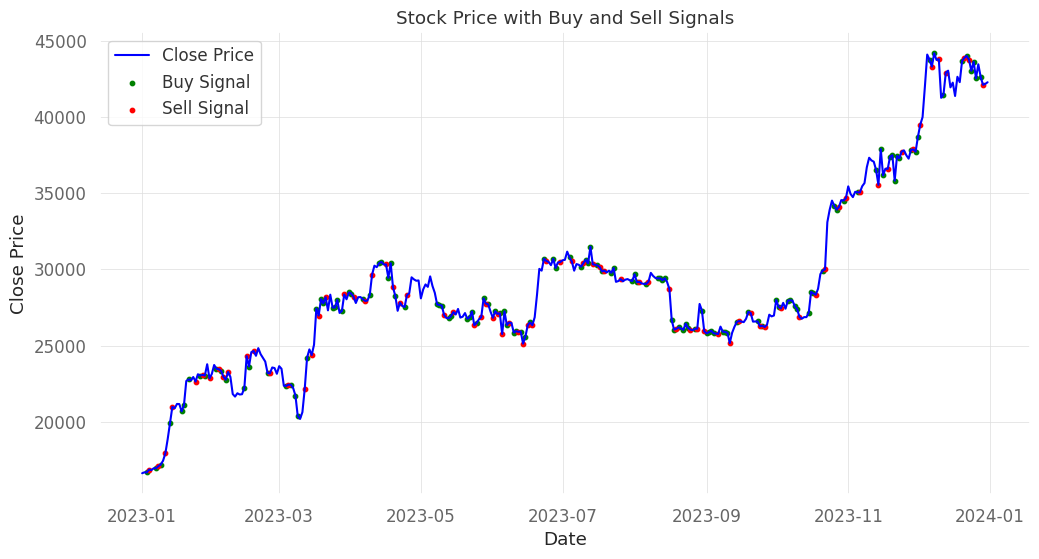

                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-12-30
Risk-Free Rate      0.0%
Time in Market      43.0%

Cumulative Return   -0.8%
CAGR﹪              -0.55%

Sharpe              -0.11
Prob. Sharpe Ratio  44.59%
Sortino             -0.17
Sortino/√2          -0.12
Omega               0.97

Max Drawdown        -8.48%
Longest DD Days     257

Gain/Pain Ratio     -0.03
Gain/Pain (1M)      -0.1

Payoff Ratio        1.06
Profit Factor       0.97
Common Sense Ratio  0.77
CPC Index           0.49
Tail Ratio          0.8
Outlier Win Ratio   15.55
Outlier Loss Ratio  3.58

MTD                 -0.16%
3M                  -0.56%
6M                  -4.11%
YTD                 -0.8%
1Y                  -0.8%
3Y (ann.)           -0.55%
5Y (ann.)           -0.55%
10Y (ann.)          -0.55%
All-time (ann.)     -0.55%

Avg. Drawdown       -1.38%
Avg. Drawdown Days  35
Recovery Factor     0.08
Ulcer Index         0.04
Serenity Index      

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


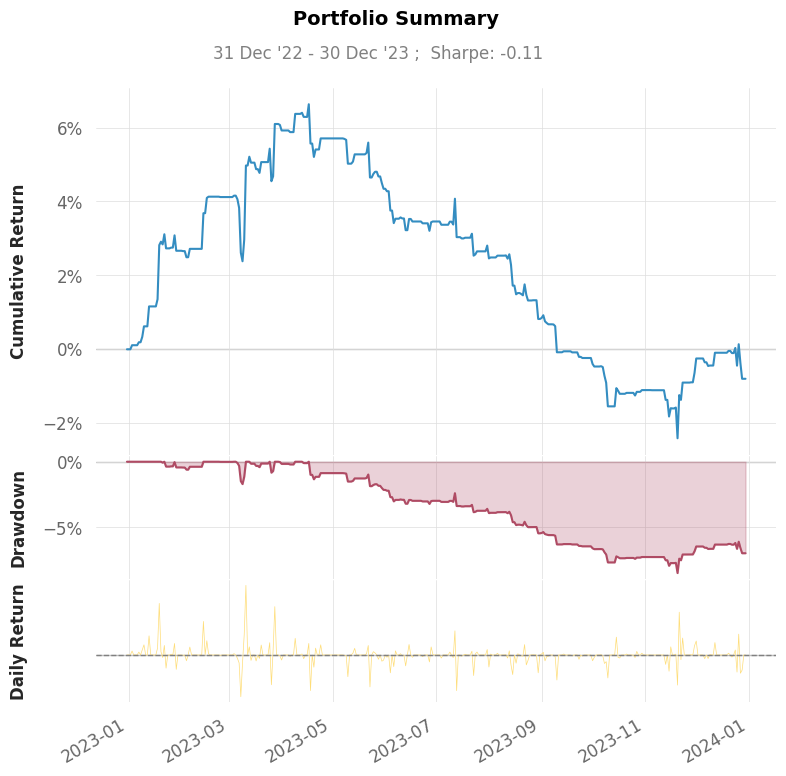

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


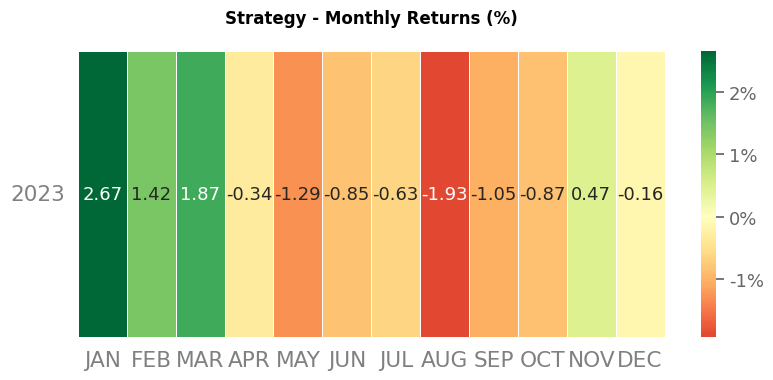

In [ ]:
import pandas as pd
import quantstats as qs
from utils.plot_buy_and_sell import plot_buy_and_sell

test_data = fetch_data(Api.YAHOO, 'BTC-USD', '2023-01-01', '2024-01-01')

test_env = CustomEnv(test_data, action_space=3, observation_space=5)
check_env(test_env)

portfolio_values = []

observation, info = test_env.reset()

while True:
    action, _states = model.predict(observation)

    observation, reward, terminated, truncated, info = test_env.step(action)
    test_env.render()
    done = terminated or truncated
    portfolio_values.append(info['portfolio_value'])

    if done:
        break

actions_data = test_env.close()
actions_data.index = pd.to_datetime(test_data.index)

plot_buy_and_sell(actions_data)

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="D")
portfolio_series = pd.Series(portfolio_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)